In [1]:
%pip install pandas


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
def load_data(folder):
    data = []
    labels = []
    for label, subfolder in enumerate(['control', 'condition']):
        path = os.path.join(folder, subfolder)
        for file in os.listdir(path):
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(path, file))
                data.append(df[['timestamp', 'activity']].values)
                labels.append(label)
    return data, labels

data, labels = load_data('data')

def preprocess_data(data):
    processed_data = []
    for sequence in data:
        df = pd.DataFrame(sequence, columns=['timestamp', 'activity'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour'] = df['timestamp'].dt.hour
        processed_data.append(df[['hour', 'activity']].values)
    return processed_data

processed_data = preprocess_data(data)

scaler = StandardScaler()
for i in range(len(processed_data)):
    processed_data[i] = scaler.fit_transform(processed_data[i])

In [5]:
def add_noise(data, noise_factor=0.1):
    noisy_data = []
    for sequence in data:
        noise = np.random.normal(loc=0.0, scale=noise_factor, size=sequence.shape)
        noisy_sequence = sequence + noise
        noisy_data.append(noisy_sequence)
    return noisy_data

def scale_data(data, scaling_factor=1.1):
    scaled_data = []
    for sequence in data:
        scaling = np.random.uniform(low=1.0/scaling_factor, high=scaling_factor)
        scaled_sequence = sequence * scaling
        scaled_data.append(scaled_sequence)
    return scaled_data

# Apply noise and scaling to the processed data
noisy_data = add_noise(processed_data)
scaled_data = scale_data(processed_data)

# Combine original, noisy, and scaled data
augmented_data = processed_data + noisy_data + scaled_data
augmented_labels = labels * 3

In [6]:
max_len = max(len(seq) for seq in augmented_data)
X = pad_sequences(augmented_data, maxlen=max_len, dtype='float32', padding='post', truncating='post')
y = np.array(augmented_labels)


In [7]:
# Reshape X for SMOTE
n_samples, time_steps, n_features = X.shape
X_reshaped = X.reshape((n_samples, time_steps * n_features))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y)

# Reshape X back to original form
X_resampled = X_resampled.reshape((X_resampled.shape[0], time_steps, n_features))


In [8]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
histories = []
fold = 1

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_model(input_shape)

    # Callbacks for early stopping and saving the best model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_model_fold_{fold}.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    histories.append(history)
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold} - Test Accuracy: {accuracy:.4f}')
    accuracies.append(accuracy)
    fold += 1

print(f'Mean Test Accuracy: {np.mean(accuracies):.4f}')

Epoch 1/20


c:\Users\vinse\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77s/step - accuracy: 0.4850 - loss: 2.0345  
Epoch 1: val_loss improved from inf to 0.79895, saving model to best_model_fold_1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 305s 78s/step - accuracy: 0.4978 - loss: 2.1167 - val_accuracy: 0.8710 - val_loss: 0.7989
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81s/step - accuracy: 0.8508 - loss: 1.0831  
Epoch 2: val_loss did not improve from 0.79895
4/4 ━━━━━━━━━━━━━━━━━━━━ 330s 83s/step - accuracy: 0.8445 - loss: 1.1074 - val_accuracy: 0.8710 - val_loss: 1.4151
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82s/step - accuracy: 0.9325 - loss: 0.5092  
Epoch 3: val_loss improved from 0.79895 to 0.00008, saving model to best_model_fold_1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 332s 83s/step - accuracy: 0.9378 - loss: 0.4856 - val_accuracy: 1.0000 - val_loss: 7.5439e-05
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84s/step - accuracy: 0.8792 - loss: 0.4101  
Epoch 4: val_loss did not improve from 0.00008
4/4 ━━━━━━━━━━━━━━━━━━━━ 340s 86s/step - accuracy: 0

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')
# Model Evaluation Section
# Assuming you have the true labels and predictions ready
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions if needed

# Insert the new code here
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='binary')  # Use 'micro', 'macro', 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the scores
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Test Accuracy: 0.9211
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
Precision: 0.8889
Recall: 1.0000
F1 Score: 0.9412


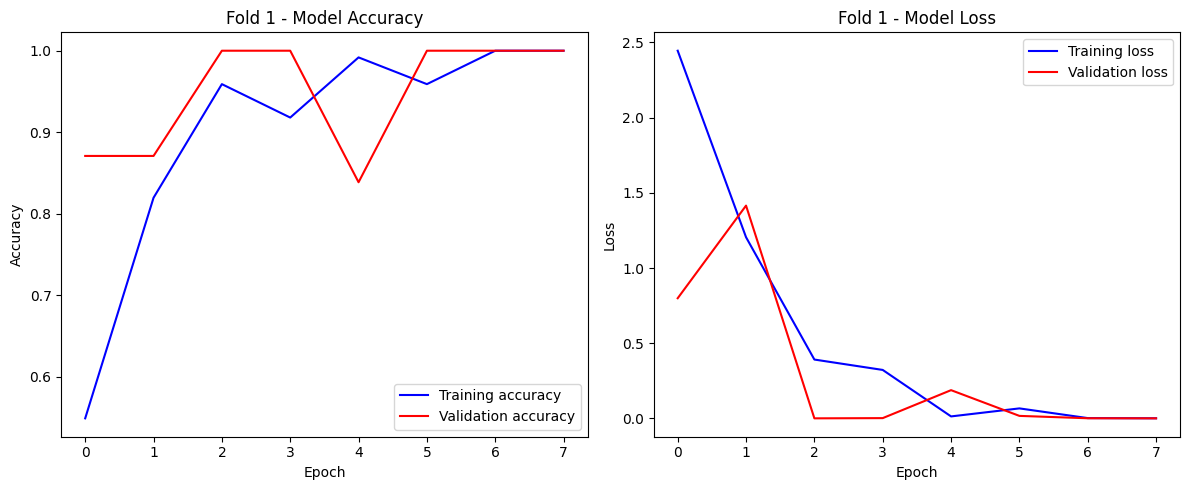

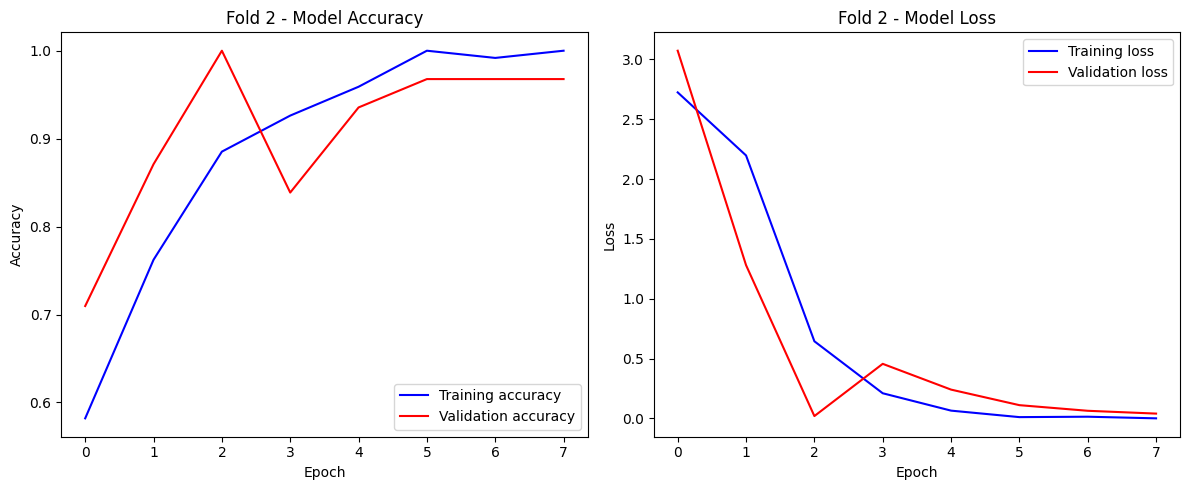

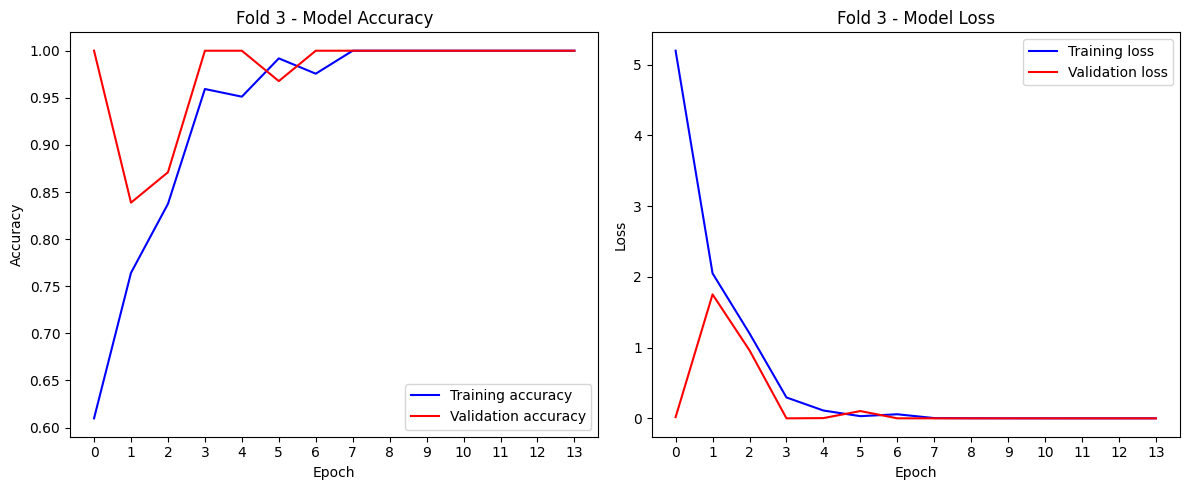

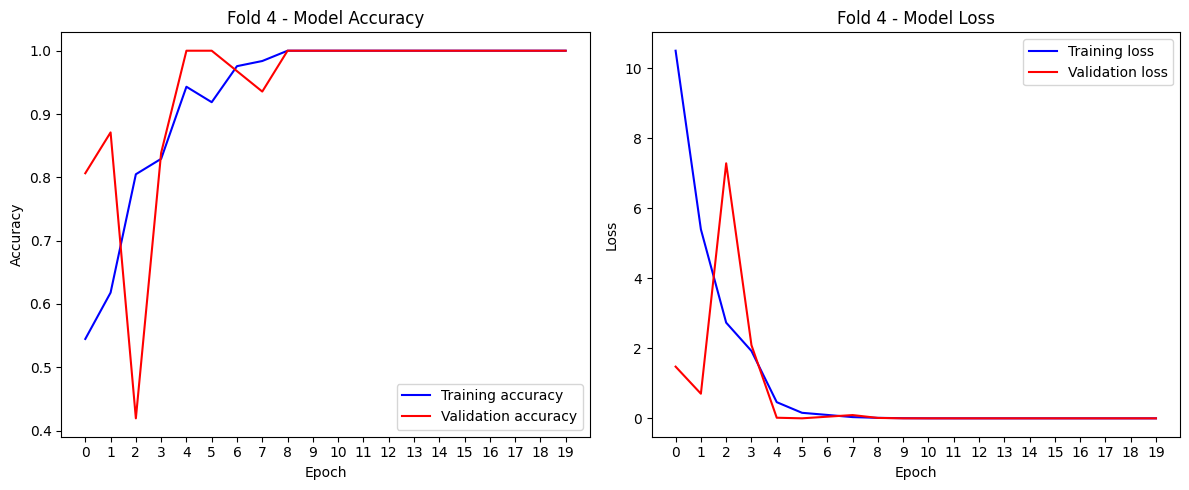

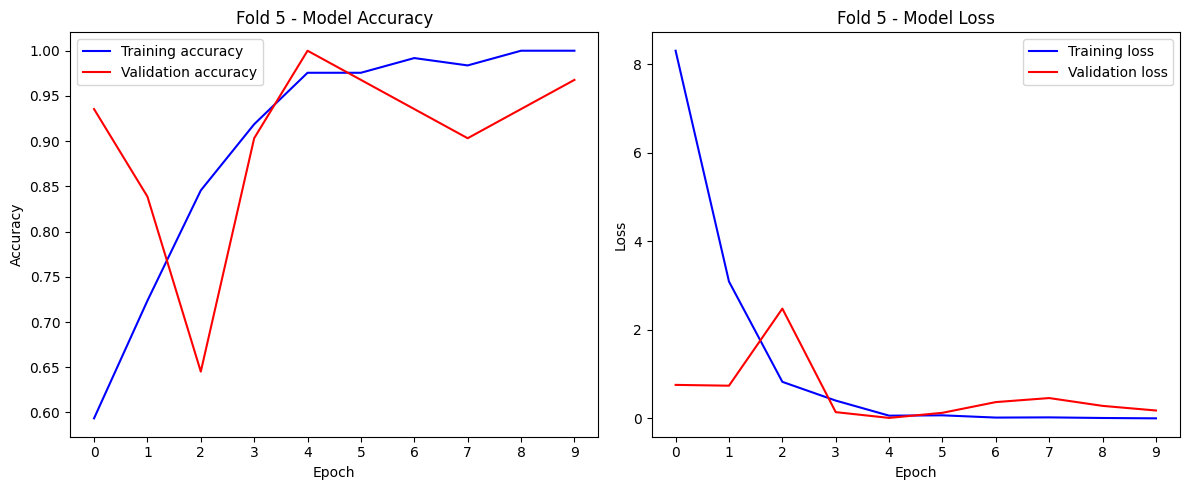

In [13]:
# Plot accuracy and loss
for i, history in enumerate(histories):

    epochs = range(len(history.history['accuracy']))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b', label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation accuracy')
    plt.title(f'Fold {i+1} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, len(epochs), 1))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
    plt.title(f'Fold {i+1} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(0, len(epochs), 1))
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# dibawah code awal

In [15]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
fold = 1

for train_index, test_index in kf.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_model(input_shape)

    # Callbacks for early stopping and saving the best model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_model_fold_{fold}.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold} - Test Accuracy: {accuracy:.4f}')
    accuracies.append(accuracy)
    fold += 1

print(f'Mean Test Accuracy: {np.mean(accuracies):.4f}')


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84s/step - accuracy: 0.6124 - loss: 3.5544  
Epoch 1: val_loss improved from inf to 0.00705, saving model to best_model_fold_1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 332s 85s/step - accuracy: 0.6194 - loss: 3.6976 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 147s/step - accuracy: 0.8422 - loss: 1.3503  
Epoch 2: val_loss did not improve from 0.00705
4/4 ━━━━━━━━━━━━━━━━━━━━ 589s 149s/step - accuracy: 0.8475 - loss: 1.2992 - val_accuracy: 0.7419 - val_loss: 2.3926
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94s/step - accuracy: 0.9120 - loss: 0.7955  
Epoch 3: val_loss did not improve from 0.00705
4/4 ━━━━━━━━━━━━━━━━━━━━ 383s 97s/step - accuracy: 0.9165 - loss: 0.7473 - val_accuracy: 0.9032 - val_loss: 0.1567
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99s/step - accuracy: 0.9585 - loss: 0.2279   
Epoch 4: val_loss improved from 0.00705 to 0.00096, saving model to best_model_fold_1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 401s 101s/step - 

In [17]:
import matplotlib.pyplot as plt

for i, history in enumerate(histories):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i+1} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i+1} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

NameError: name 'histories' is not defined